In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from itertools import product

# Set random seed for reproducibility
torch.manual_seed(0)

# Torch version
torch.__version__

'2.4.1+cu124'

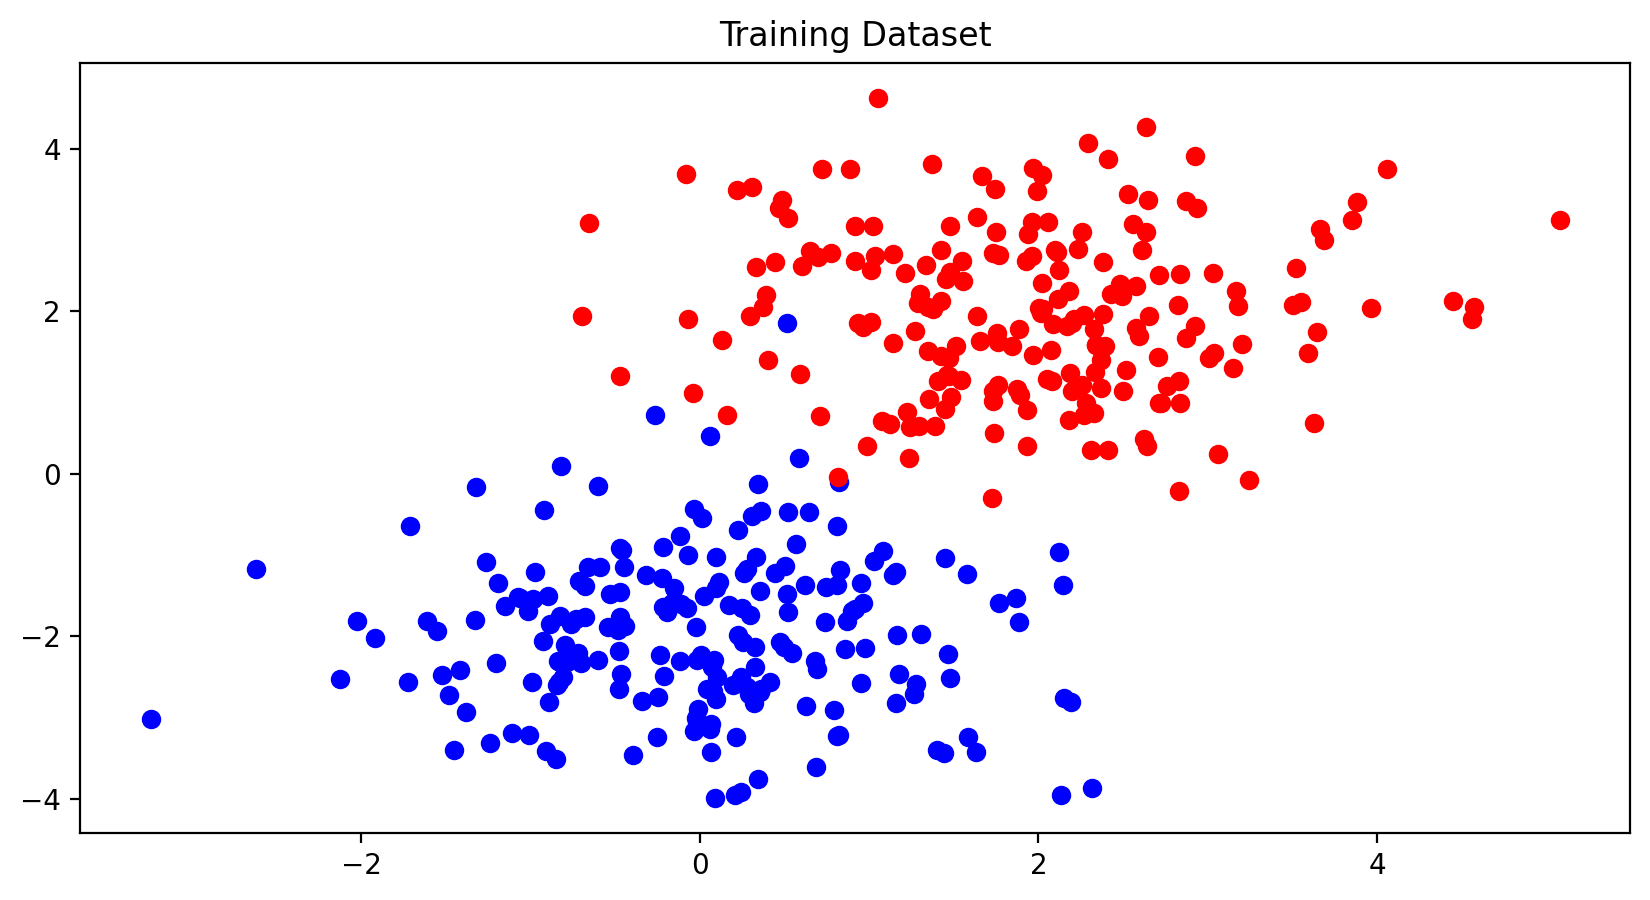

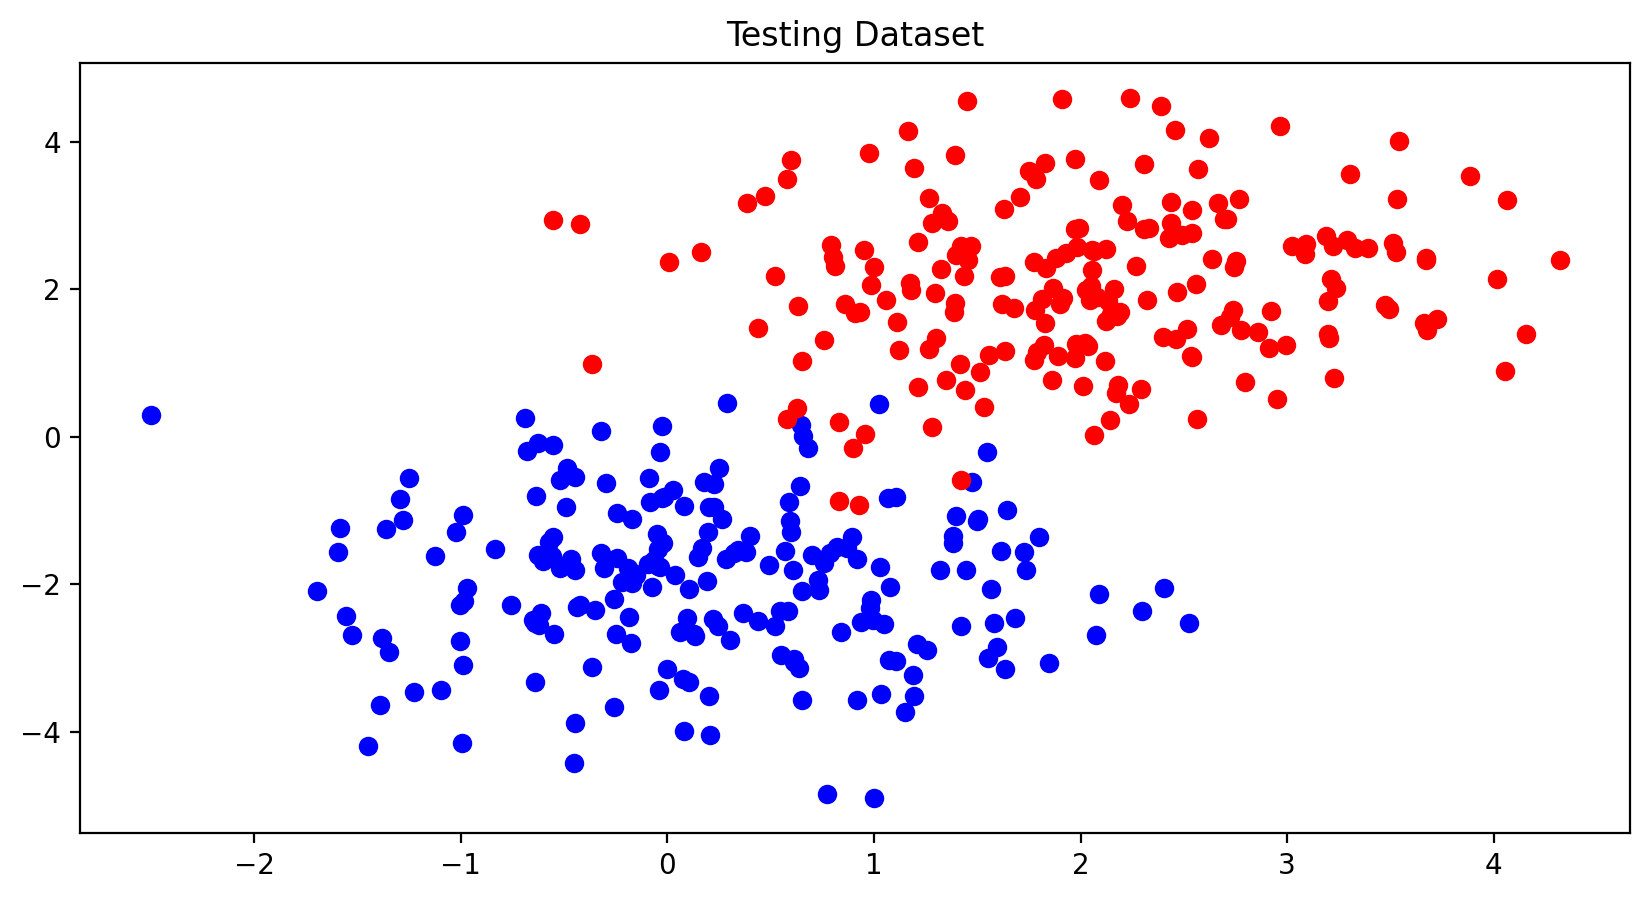

In [27]:
np.random.seed(42)

num_train_samples = 200
num_test_samples = 200

# Training Set for two classes
X1 = np.random.randn(num_train_samples, 2) + np.array([0, -2])
X2 = np.random.randn(num_train_samples, 2) + np.array([2, 2])

X_train = np.vstack([X1, X2])
Y_train = np.array([0] * num_train_samples + [1] * num_train_samples)

# Testing Set for two classes
X1 = np.random.randn(num_test_samples, 2) + np.array([0, -2])
X2 = np.random.randn(num_test_samples, 2) + np.array([2, 2])

X_test = np.vstack([X1, X2])
Y_test = np.array([0] * num_test_samples + [1] * num_test_samples)

# Plotting the data of training data
plt.figure(figsize=(10, 5))
plt.scatter(X_train[Y_train == 0][:, 0], X_train[Y_train == 0][:, 1], color='blue')
plt.scatter(X_train[Y_train == 1][:, 0], X_train[Y_train == 1][:, 1], color='red')
plt.title('Training Dataset')
plt.show()

# Plotting the data of testing data
plt.figure(figsize=(10, 5))
plt.scatter(X_test[Y_test == 0][:, 0], X_test[Y_test == 0][:, 1], color='blue')
plt.scatter(X_test[Y_test == 1][:, 0], X_test[Y_test == 1][:, 1], color='red')
plt.title('Testing Dataset')
plt.show()




In [28]:
targets_train = torch.tensor(Y_train, dtype=torch.float32)
targets_train = targets_train.reshape(-1, 1)

targets_test = torch.tensor(Y_test, dtype=torch.float32)
targets_test = targets_test.reshape(-1, 1)

In [29]:
torch.manual_seed(42)
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x    
    
    

# a

In [30]:
def train_model(model, criterion, optimizer, x_train, y_train, num_epochs, batch_size):           
    for epoch in range(num_epochs):
        for i in range(0, x_train.shape[0], batch_size):
            x = torch.tensor(x_train, dtype=torch.float32)[i:i+batch_size]
            y = y_train[i:i+batch_size]
            
            outputs = model.forward(x)

            loss = criterion(outputs,y)

            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
            
    return model

In [31]:
def accuracy(predicted,true_labels):
    result = torch.where(predicted > 0, torch.tensor(1), torch.tensor(0))
    accuracy = (result == true_labels).sum().item() / len(true_labels)
    return accuracy

In [32]:
torch.manual_seed(1)
model_to_learn_no_reg = MLP(2,4,1)
learned_model_no_reg = train_model(model_to_learn_no_reg, nn.BCEWithLogitsLoss(), optim.SGD(model_to_learn_no_reg.parameters(), lr=0.1), X_train, targets_train, 1000, 10)
a1 = accuracy(learned_model_no_reg.forward(torch.tensor(X_test, dtype=torch.float32)), targets_test)
print(f'Accuracy on the testing set: {a1*100:.2f} %')

Epoch 0, Loss: 0.39496442675590515
Epoch 100, Loss: 0.008420519530773163
Epoch 200, Loss: 0.005976920016109943
Epoch 300, Loss: 0.005377904046326876
Epoch 400, Loss: 0.005180031061172485
Epoch 500, Loss: 0.005100496578961611
Epoch 600, Loss: 0.0050520929507911205
Epoch 700, Loss: 0.0050157723017036915
Epoch 800, Loss: 0.004998672753572464
Epoch 900, Loss: 0.005009423941373825
Accuracy on the testing set: 98.25 %


# b 

In [36]:
def train_model_with_l1_reg(model, criterion, optimizer, x_train, y_train, num_epochs, batch_size, regularisation_coeff):
    for epoch in range(num_epochs):
        for i in range(0, x_train.shape[0], batch_size):
            x = torch.tensor(x_train, dtype=torch.float32)[i:i+batch_size]
            y = y_train[i:i+batch_size]
            outputs = model.forward(x)

            loss = criterion(outputs,y)
            l1_regularization = torch.tensor(0.)
            for param in model.parameters():
                l1_regularization += torch.norm(param, p=1)
            loss += regularisation_coeff * l1_regularization

            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
            
    return model

In [37]:
def accuracy(predicted,true_labels):
    result = torch.where(predicted > 0, torch.tensor(1), torch.tensor(0))
    accuracy = (result == true_labels).sum().item() / len(true_labels)
    return accuracy

In [38]:
torch.manual_seed(1)
model_to_learn_l1 = MLP(2,4,1)
learned_model_l1 = train_model_with_l1_reg(model_to_learn_l1, nn.BCEWithLogitsLoss(), optim.SGD(model_to_learn_l1.parameters(), lr=0.01), X_train, targets_train, 1000, 20, 0.001)
a2 = accuracy(learned_model_l1.forward(torch.tensor(X_test, dtype=torch.float32)), targets_test)
print(f'Accuracy on the testing set: {a2*100:.2f} %')

Epoch 0, Loss: 0.6594247221946716
Epoch 100, Loss: 0.1730126142501831
Epoch 200, Loss: 0.0926017016172409
Epoch 300, Loss: 0.06826193630695343
Epoch 400, Loss: 0.056643400341272354
Epoch 500, Loss: 0.04998178407549858
Epoch 600, Loss: 0.04564201086759567
Epoch 700, Loss: 0.042605116963386536
Epoch 800, Loss: 0.04037410765886307
Epoch 900, Loss: 0.03867039829492569
Accuracy on the testing set: 98.25 %


# c

In [39]:
def train_model_with_l2_reg(model, criterion, optimizer, x_train, y_train, num_epochs, batch_size, regularisation_coeff):
    for epoch in range(num_epochs):
        for i in range(0, x_train.shape[0], batch_size):
            x = torch.tensor(x_train, dtype=torch.float32)[i:i+batch_size]
            y = y_train[i:i+batch_size]
            outputs = model.forward(x)

            loss = criterion(outputs,y)
            l2_regularization = torch.tensor(0.)
            for param in model.parameters():
                l2_regularization += torch.norm(param, p=2)
            loss += regularisation_coeff * l2_regularization

            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
            
    return model

In [40]:
def accuracy(predicted,true_labels):
    result = torch.where(predicted > 0, torch.tensor(1), torch.tensor(0))
    accuracy = (result == true_labels).sum().item() / len(true_labels)
    return accuracy

In [41]:
torch.manual_seed(1)
model_to_learn_l2 = MLP(2,4,1)
learned_model_l2 = train_model_with_l2_reg(model_to_learn_l2, nn.BCEWithLogitsLoss(), optim.SGD(model_to_learn_l2.parameters(), lr=0.01), X_train, targets_train, 1000, 20, 0.01)
a3 = accuracy(learned_model_l2.forward(torch.tensor(X_test, dtype=torch.float32)), targets_test)
print(f'Accuracy on the testing set: {a3*100:.2f} %')

Epoch 0, Loss: 0.691017746925354
Epoch 100, Loss: 0.2566620111465454
Epoch 200, Loss: 0.18256282806396484
Epoch 300, Loss: 0.16243137419223785
Epoch 400, Loss: 0.1529715657234192
Epoch 500, Loss: 0.1472170054912567
Epoch 600, Loss: 0.1434558480978012
Epoch 700, Loss: 0.1408528983592987
Epoch 800, Loss: 0.13893531262874603
Epoch 900, Loss: 0.137392058968544
Accuracy on the testing set: 98.00 %


# d

In [44]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        logits = self.linear(x)
        return logits

In [45]:
# Using only x1 and x2 as features
model1 = LogisticRegression(2)
opt1 = torch.optim.Adam(model1.parameters(), lr=0.01)

converged = False
prev_loss = 1e8 
i = 0
while not converged:
    opt1.zero_grad()
    logits = model1(torch.tensor(X_train, dtype=torch.float32))
    loss = nn.BCEWithLogitsLoss()(logits, targets_train)
    loss.backward()
    opt1.step()
    if i%10==0:
        print(i, loss.item())
    if np.abs(prev_loss - loss.item()) < 1e-5:
        converged = True
    prev_loss = loss.item() 
    i = i + 1

0 0.5148341655731201
10 0.4023253619670868
20 0.3235757350921631
30 0.2702750563621521
40 0.23287618160247803
50 0.20507872104644775
60 0.18355907499790192
70 0.16647139191627502
80 0.15263307094573975
90 0.14122532308101654
100 0.1316685676574707
110 0.123548224568367
120 0.11656349152326584
130 0.11049184203147888
140 0.10516535490751266
150 0.100455142557621
160 0.09626030176877975
170 0.09250088781118393
180 0.08911264687776566
190 0.08604341745376587
200 0.08325038105249405
210 0.08069794625043869
220 0.07835651189088821
230 0.07620109617710114
240 0.07421046495437622
250 0.07236652076244354
260 0.0706537663936615
270 0.06905874609947205
280 0.06756984442472458
290 0.0661768764257431
300 0.06487094610929489
310 0.06364420056343079
320 0.062489744275808334
330 0.06140142306685448
340 0.06037377938628197
350 0.05940192565321922
360 0.058481503278017044
370 0.05760858952999115
380 0.0567796565592289
390 0.055991511791944504
400 0.055241238325834274
410 0.054526254534721375
420 0.0538

In [46]:
prediction_train = model1(torch.tensor(X_train, dtype=torch.float32))
prediction_test = model1(torch.tensor(X_test, dtype=torch.float32))
probs_train = torch.sigmoid(prediction_train)
print(probs_train.max(), probs_train.min())
probs_test = torch.sigmoid(prediction_test)
y_pred_train = (probs_train > 0.5).float()
y_pred_test = (probs_test > 0.5).float()
train_accuracy = (y_pred_train == targets_train).sum().item() / len(targets_test)
test_accuracy = (y_pred_test == targets_test).sum().item() / len(targets_test)
print(f'Train accuracy: {train_accuracy:.2f}, Test accuracy: {test_accuracy:.2f}')

tensor(1.0000, grad_fn=<MaxBackward1>) tensor(2.3992e-07, grad_fn=<MinBackward1>)
Train accuracy: 0.99, Test accuracy: 0.98


In [48]:
# Using x1, x2, x1**2 and x2**2 as features

x1 = X_train[:, 0] 
x2 = X_train[:, 1] 

x1_sq = x1**2
x2_sq = x2**2

x_with_squares = np.concatenate((X_train, np.expand_dims(x1_sq, axis=1)), axis=1)
x_with_squares = np.concatenate((x_with_squares, np.expand_dims(x2_sq, axis=1)), axis=1)

model2 = LogisticRegression(4)
opt2 = torch.optim.Adam(model2.parameters(), lr=0.01)

converged = False
prev_loss = 1e8 
i = 0
while not converged:
    opt2.zero_grad()
    logits = model2(torch.tensor(x_with_squares, dtype=torch.float32))
    loss = nn.BCEWithLogitsLoss()(logits, targets_train)
    loss.backward()
    opt2.step()
    if i%10==0:
        print(i, loss.item())
    if np.abs(prev_loss - loss.item()) < 1e-5:
        converged = True
    prev_loss = loss.item() 
    i = i + 1

0 0.6666311621665955
10 0.5123078227043152
20 0.43545010685920715
30 0.374154269695282
40 0.3269845247268677
50 0.28759488463401794
60 0.25571614503860474
70 0.2297472208738327
80 0.20843864977359772
90 0.19070473313331604
100 0.17580245435237885
110 0.16316145658493042
120 0.15233981609344482
130 0.14299248158931732
140 0.13485164940357208
150 0.12770728766918182
160 0.1213933452963829
170 0.1157773956656456
180 0.11075282841920853
190 0.10623308271169662
200 0.10214734077453613
210 0.09843709319829941
220 0.09505370259284973
230 0.0919564887881279
240 0.0891110971570015
250 0.08648835867643356
260 0.08406344056129456
270 0.08181498199701309
280 0.07972459495067596
290 0.07777627557516098
300 0.07595617324113846
310 0.07425212860107422
320 0.07265343517065048
330 0.07115066796541214
340 0.06973551958799362
350 0.06840059161186218
360 0.06713925302028656
370 0.06594567000865936
380 0.0648145079612732
390 0.0637410432100296
400 0.06272097676992416
410 0.061750445514917374
420 0.06082592

In [49]:
x11 = X_test[:, 0]
x12 = X_test[:, 1]
x_test_with_squares = np.concatenate((X_test, np.expand_dims(x11**2, axis=1)), axis=1)
x_test_with_squares = np.concatenate((x_test_with_squares, np.expand_dims(x12**2, axis=1)), axis=1)

prediction_train = model2(torch.tensor(x_with_squares, dtype=torch.float32))
prediction_test = model2(torch.tensor(x_test_with_squares, dtype=torch.float32))
probs_train = torch.sigmoid(prediction_train)
probs_test = torch.sigmoid(prediction_test)
y_pred_train = (probs_train > 0.5).float()
y_pred_test = (probs_test > 0.5).float()
train_accuracy = (y_pred_train == targets_train).sum().item() / len(targets_test)
test_accuracy = (y_pred_test == targets_test).sum().item() / len(targets_test)
print(f'Train accuracy: {train_accuracy:.2f}, Test accuracy: {test_accuracy:.2f}')

Train accuracy: 0.99, Test accuracy: 0.98


In [50]:
x_only_with_squares = x_with_squares[:, 2:]
model3 = LogisticRegression(2)
opt2 = torch.optim.Adam(model3.parameters(), lr=0.01)

converged = False
prev_loss = 1e8 
i = 0
while not converged:
    opt2.zero_grad()
    logits = model3(torch.tensor(x_only_with_squares, dtype=torch.float32))
    loss = nn.BCEWithLogitsLoss()(logits, targets_train)
    loss.backward()
    opt2.step()
    if i%10==0:
        print(i, loss.item())
    if np.abs(prev_loss - loss.item()) < 1e-5:
        converged = True
    prev_loss = loss.item() 
    i = i + 1

0 0.7365540862083435
10 0.6029030680656433
20 0.5656182169914246
30 0.5563987493515015
40 0.5436923503875732
50 0.5338786840438843
60 0.5261695384979248
70 0.5191291570663452
80 0.5131701231002808
90 0.5079269409179688
100 0.5033465027809143
110 0.4993222951889038
120 0.49579837918281555
130 0.49272000789642334
140 0.49003899097442627
150 0.487710177898407
160 0.48569294810295105
170 0.48395034670829773
180 0.4824489653110504
190 0.4811587929725647
200 0.4800530970096588
210 0.47910788655281067
220 0.47830215096473694
230 0.4776170253753662
240 0.4770360589027405
250 0.4765447676181793
260 0.4761304557323456
270 0.47578200697898865
280 0.47548985481262207
290 0.47524550557136536
300 0.47504180669784546
310 0.4748724699020386
320 0.4747321307659149
330 0.4746161699295044


In [51]:
x11 = X_test[:, 0]
x12 = X_test[:, 1]

x11_sq = x11 ** 2
x12_sq = x12 ** 2
x_test_only_with_squares = np.column_stack((x11_sq, x12_sq))

prediction_train = model3(torch.tensor(x_only_with_squares, dtype=torch.float32))
prediction_test = model3(torch.tensor(x_test_only_with_squares, dtype=torch.float32))
probs_train = torch.sigmoid(prediction_train)
probs_test = torch.sigmoid(prediction_test)
y_pred_train = (probs_train > 0.5).float()
y_pred_test = (probs_test > 0.5).float()
train_accuracy = (y_pred_train == targets_train).sum().item() / len(targets_test)
test_accuracy = (y_pred_test == targets_test).sum().item() / len(targets_test)
print(f'Train accuracy: {train_accuracy:.2f}, Test accuracy: {test_accuracy:.2f}')

Train accuracy: 0.78, Test accuracy: 0.78


# Decision Surface

In [52]:
def predict_plot_grid(model,s):
    XX, YY = torch.meshgrid(torch.linspace(-6, 6, 100), torch.linspace(-6, 6, 100))
    labels = torch.where(torch.sign(XX) == torch.sign(YY), torch.tensor(0), torch.tensor(1))
    labels = labels.reshape(XX.shape)

    X_grid = torch.cat([XX.unsqueeze(-1), YY.unsqueeze(-1)], dim=-1)
    logits = model.forward(X_grid)
    probs = torch.sigmoid(logits).reshape(100, 100)
    plt.contourf(XX, YY, probs.detach().numpy(), levels=[0.0, 0.1, 0.2,0.3, 0.4,0.5, 0.6,0.7, 0.8,0.9, 1.0], 
                 cmap=plt.cm.Spectral, alpha=0.5)
    plt.colorbar()
    
    plt.scatter(X_train[:, 0],X_train[:, 1], c=Y_train, cmap=plt.cm.Spectral)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(s)


In [53]:
def predict_plot_grid_square_features(model):
    XX, YY = torch.meshgrid(torch.linspace(-6, 6, 100), torch.linspace(-6, 6, 100))
    XX_sq = XX ** 2
    YY_sq = YY ** 2
    X_grid = torch.cat([XX_sq.unsqueeze(-1), YY_sq.unsqueeze(-1)], dim=-1)
    logits = model.forward(X_grid)
    probs = torch.sigmoid(logits).reshape(100, 100)
    plt.contourf(XX, YY, probs.detach().numpy(), levels=[0.0, 0.1, 0.2,0.3, 0.4,0.5, 0.6,0.7, 0.8,0.9, 1.0], 
                 cmap=plt.cm.Spectral, alpha=0.5)
    plt.colorbar()
    
    plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap=plt.cm.Spectral)
    plt.xlabel('x1^2')
    plt.ylabel('x2^2')
    plt.title('Decision Surface for Logistic Regression with feature engineering')


In [54]:
def predict_plot_grid_product_features(model):
    XX, YY = torch.meshgrid(torch.linspace(-6, 6, 100), torch.linspace(-6, 6, 100))
    X_Y = XX * YY
    X_grid = torch.cat([XX.unsqueeze(-1), X_Y.unsqueeze(-1)], dim=-1)
    logits = model.forward(X_grid)
    probs = torch.sigmoid(logits).reshape(100, 100)
    plt.contourf(XX, YY, probs.detach().numpy(), levels=[0.0, 0.1, 0.2,0.3, 0.4,0.5, 0.6,0.7, 0.8,0.9, 1.0], 
                 cmap=plt.cm.Spectral, alpha=0.5)
    plt.colorbar()
    
    
    plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap=plt.cm.Spectral)
    plt.xlabel('x1')
    plt.ylabel('x1*x2')
    plt.title('Decision Surface for Logistic Regression with feature engineering')


# For normal MLP model

c:\Users\abhay\anaconda3\envs\yolov5-env\lib\site-packages\torch\functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3610.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


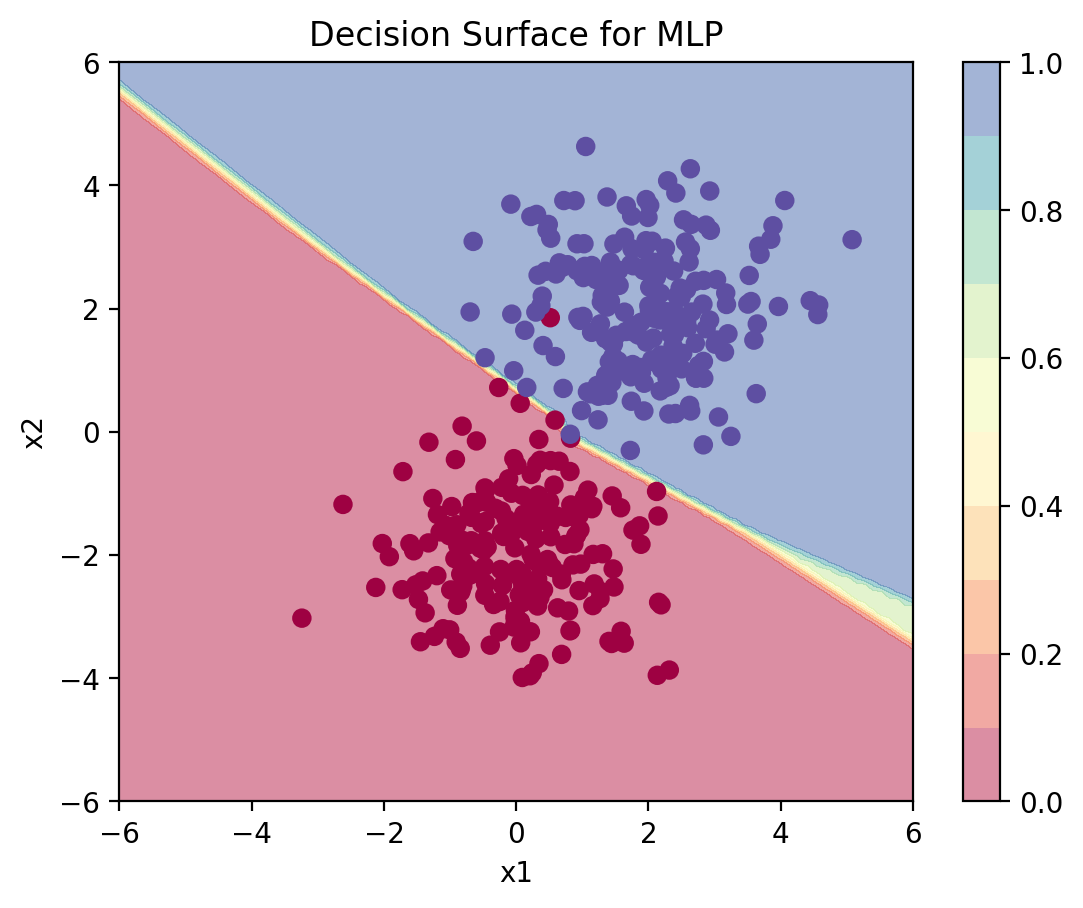

In [55]:
predict_plot_grid(learned_model_no_reg, 'Decision Surface for MLP')

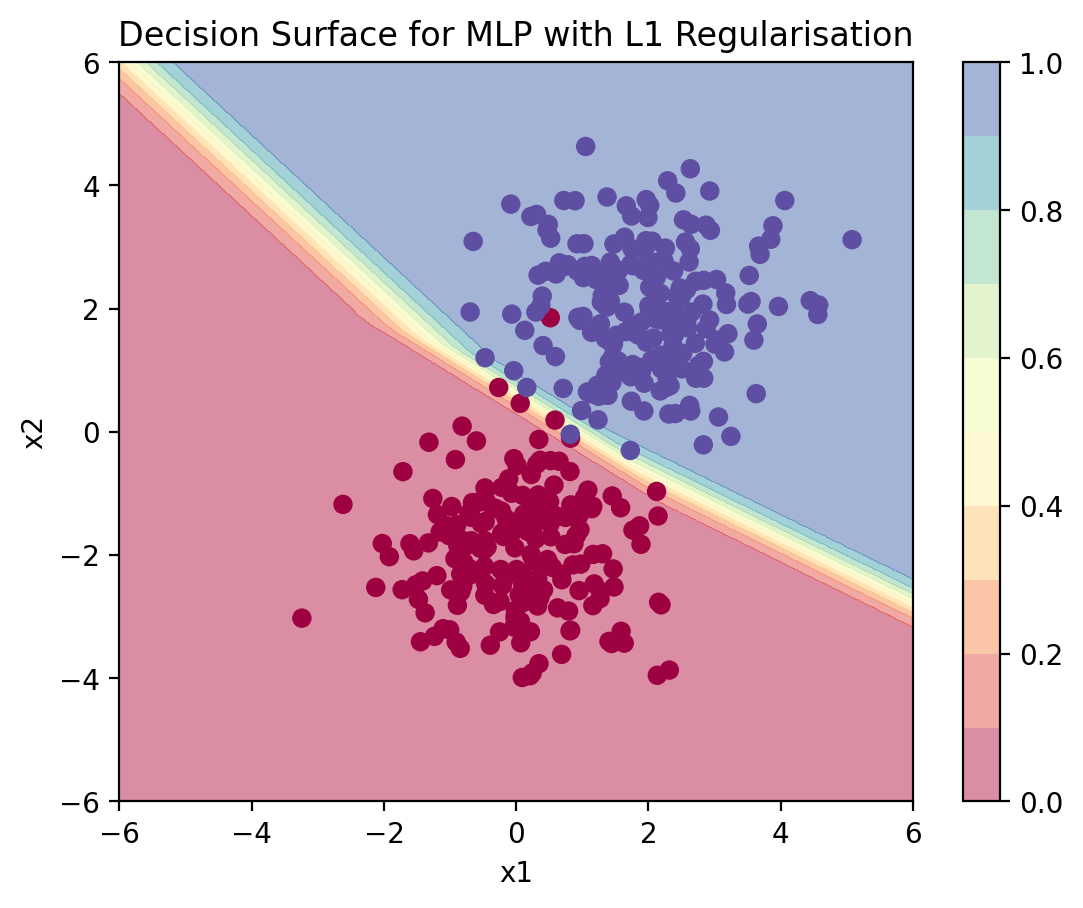

In [56]:
predict_plot_grid(learned_model_l1, 'Decision Surface for MLP with L1 Regularisation')

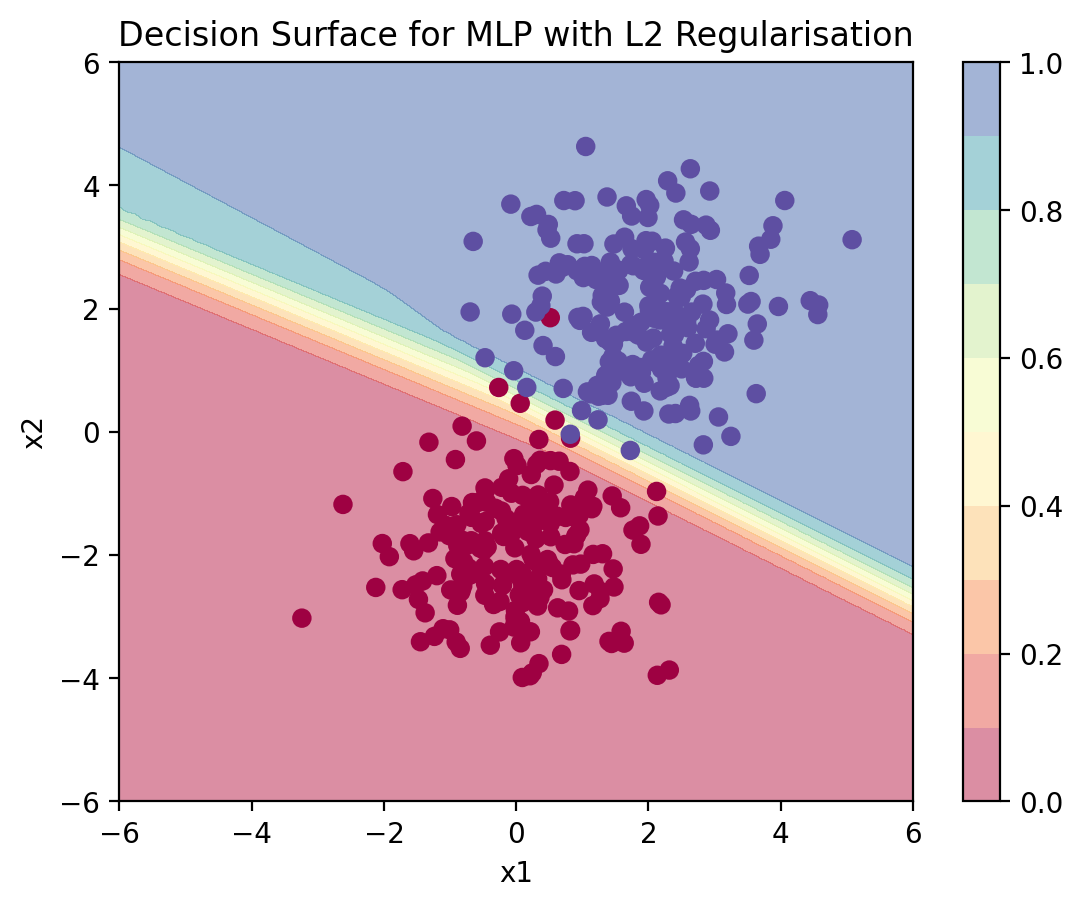

In [57]:
predict_plot_grid(learned_model_l2, 'Decision Surface for MLP with L2 Regularisation')

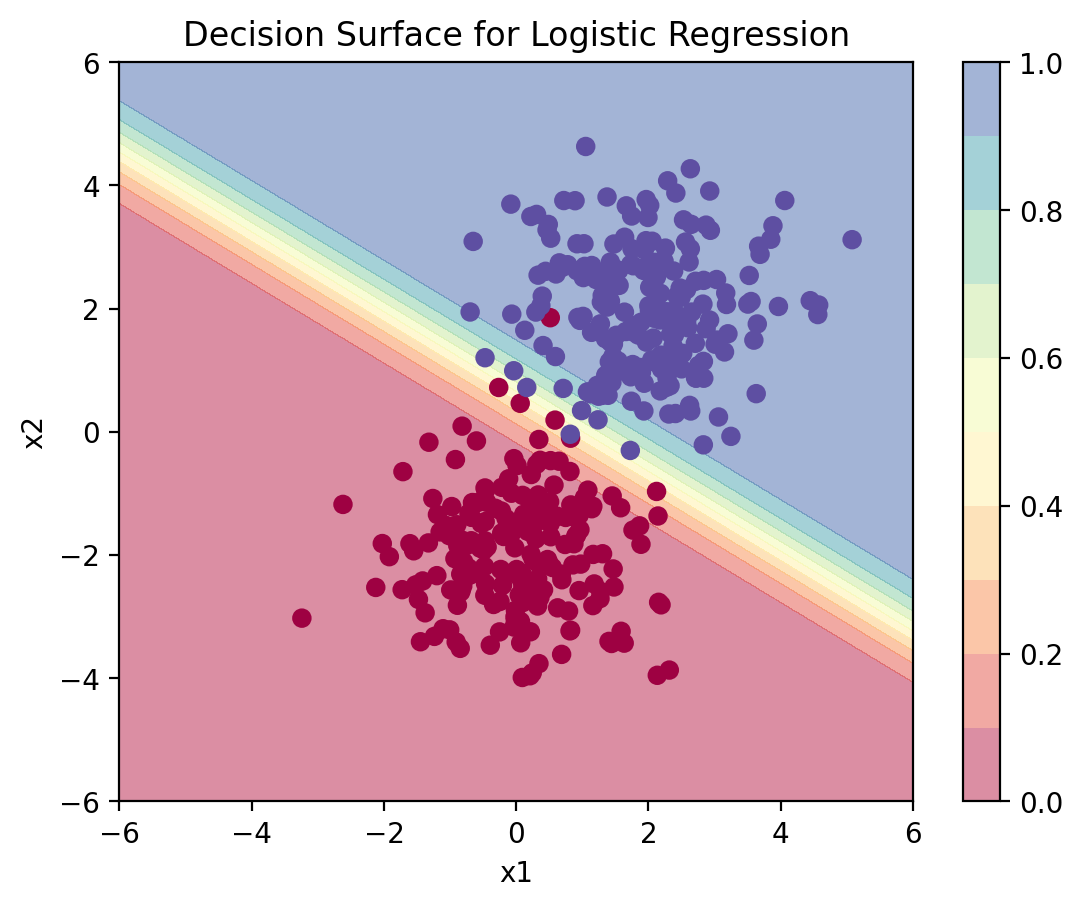

In [58]:
predict_plot_grid(model1, 'Decision Surface for Logistic Regression')